# Linear Logistic Regression in NumPy

Fast logistic regression in NumPy with Conjugate Gradients from the SciPy optimize module.

In [1]:
import numpy as np
import scipy.optimize as spopt

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

Some basic numerical functions, `cap_zero` takes values very close or equal to zero and makes them "tiny" non-zero values.  `softmax` computes the softmax along the last axis of a multi-axis array and `log_softmax` compute the natural log of the softmax along the last axis, in a way that is slightly faster and more numerically stable than computing the direct log of `softmax`.

In [2]:
def cap_zero(x, value=None):
    '''Return a copy of `x` where all values are capped at `value`,
    i.e., no values in the array are less than `value`.  If `value`
    is `None` (default) then the `np.finfo` `tiny` value is used
    for the `dtype` of `x`.
    '''
    if value is None:
        value = np.finfo(x.dtype).tiny
    x = x.copy()
    x[x < value] = value
    return x

def softmax(x):
    '''Compute the softmax of `x` along the last axis.'''
    mx = np.max((np.max(x), 0.0))
    terms = cap_zero(np.exp(x - mx))
    denom = np.sum(terms, axis=-1)[..., None]
    return terms / denom

def log_softmax(x):
    '''Compute the natural log of the softmax of `x` along the last axis.'''
    mx = np.max((np.max(x), 0.0))                                                                   
    xmx = x - mx                                                                                    

    terms = cap_zero(np.exp(xmx))
    denom = np.sum(terms, axis=-1)[..., None]
    log_denom = np.log(cap_zero(denom))
                                                                                                             
    return xmx - log_denom

And now for the logistic regression implementation...

In [21]:
class LogisticRegression:
    '''Linear Logistic Regression.
    
    Inputs:
        x: np.array((..., ndim))
            The input features over which to perform a prediction.
            
    Outputs:
        logits: np.array((..., ncls))
            Predicted logit indicators for each class.  Higher values
            indicate a more confident prediction.  For predicted
            probabilities in (0,1), see the `.probs` method.
            For integer predicted class labels, see the `.labels` method.
    '''
    def __init__(self, ndim, ncls):
        '''Construct a new Linear Logistic Regression classifier.
        
        Args:
            ndim: int
                The number of input dimensions / features.
            ncls: int
                The number of classes in a prediction.
        '''
        self.ndim, self.ncls = ndim, ncls

        weight_scale = np.sqrt(3.0) / ndim
        self.weights = np.random.uniform(
            -weight_scale, weight_scale,
            size=(self.ndim+1, self.ncls))
        
    @property
    def parameters(self):
        '''Return a single flat NumPy array containing all of the
        parameters for this model.  Used for optimization with
        `scipy.optimize`.
        '''
        return self.weights.ravel()
        
    def __call__(self, x):
        '''Return predicted logits.'''
        assert x.ndim >= 2
        return x @ (self.weights[:-1]) + self.weights[-1]
    
    def probs(self, x):
        '''Return the predicted class membership probabilities.'''
        return softmax(self(x))
    
    def labels(self, x):
        '''Return the predicted class labels as integers.'''
        return np.argmax(self(x), axis=-1)
    
    def loss(self, x, g):
        '''Return the log loss, i.e., cross-entropy loss.'''
        likes = log_softmax(self(x))
        
        # pointwise multiplication of log likelihoods times target indicator
        # variables can be computed by simply selecting along the last axis
        likes_g = np.take_along_axis(likes, g[..., None], axis=-1)
        
        return -np.mean(likes_g)
    
    def grad(self, x, g):
        '''Return the gradient matrix using cross-entropy loss.
        This should be flattened for use with `scipy.optimize`.'''
        probs = softmax(self(x))

        delta = probs.reshape((-1, probs.shape[-1]))
        delta[range(delta.shape[0]), g.flat] -= 1.0
        
        x1 = np.concatenate((x, np.ones_like(x[..., 0])[..., None]), axis=-1)
        grad = x1.T.reshape((x1.shape[-1], -1)) @ delta
        
        return grad
    
    def train(self, x, g, precision=1.0e-6, method='cg', **options):
        '''Train this logistic regression model using `scipy.optimize.minimize`.
        The model is trained in place.
        
        Args:
            x: np.array(..., ndim)
                The training input data.
            g: np.array(...)
                Integer target class labels.
            precision: float
                The precision after which training will terminate.
            method: str
                The training method used by `scipy.optimize`.
                Defaults to `cg` conjugate gradients.
            **options:
                Additonal arguments to pass to `scipy.optimize.minimize`.
                
        Returns:
            dict
                A dictionary of result information returned by the
                `scipy.optimize.minimize` function.
        '''
        def loss_func(parameters):
            '''Set parameters on self and computes the log loss.'''
            self.parameters[...] = parameters
            return self.loss(x, g)
        
        def grad_func(parameters):
            '''Set parameters on self and compute the flattened gradient.'''
            self.parameters[...] = parameters
            return self.grad(x, g).ravel()
        
        # deligate minimization to scipy
        return spopt.minimize(
            fun=loss_func, method=method, x0=self.parameters,
            tol=precision, jac=grad_func, options=options)

A simple test with multi-axis arrays.  The last axis is for features, any earlier axes are additional observations, e.g., `number_of_sentences` x `number_of_words` x `word_embedding_size`.

In [4]:
inputs = np.random.random((4, 10, 32))
targets = np.array(inputs.sum(-1) < 0.5, dtype=np.int)

lr_model = LogisticRegression(32, 2)
opt_result = lr_model.train(inputs, targets)
print(opt_result)

logits = lr_model(inputs)
probs = lr_model.probs(inputs)
labels = lr_model.labels(inputs)
loss = lr_model.loss(inputs, targets)
grad = lr_model.grad(inputs, targets)

print('logits:', logits.shape)
print('probs:', probs.shape)
print('labels:', labels.shape)
print('loss:', loss)

     fun: 6.6747041754799846e-09
     jac: array([-1.4798e-07,  1.4798e-07, -1.1218e-07,  1.1218e-07, -8.7962e-08,
        8.7962e-08, -1.0439e-07,  1.0439e-07, -1.8720e-07,  1.8720e-07,
       -1.2147e-07,  1.2147e-07, -9.0199e-08,  9.0199e-08, -1.0157e-07,
        1.0157e-07, -1.1727e-07,  1.1727e-07, -1.3761e-07,  1.3761e-07,
       -1.2276e-07,  1.2276e-07, -9.8857e-08,  9.8857e-08, -9.2823e-08,
        9.2823e-08, -1.0574e-07,  1.0574e-07, -1.5342e-07,  1.5342e-07,
       -1.1841e-07,  1.1841e-07, -1.4300e-07,  1.4300e-07, -1.7897e-07,
        1.7897e-07, -1.0849e-07,  1.0849e-07, -9.6383e-08,  9.6383e-08,
       -1.4084e-07,  1.4084e-07, -1.9770e-07,  1.9770e-07, -1.3946e-07,
        1.3946e-07, -7.7111e-08,  7.7111e-08, -5.4045e-08,  5.4045e-08,
       -1.7158e-07,  1.7158e-07, -6.9533e-08,  6.9533e-08, -1.2656e-07,
        1.2656e-07, -1.9531e-07,  1.9531e-07, -1.0809e-07,  1.0809e-07,
       -1.7329e-07,  1.7329e-07, -1.2808e-07,  1.2808e-07, -2.6699e-07,
        2.6699e-07])


Conjugate gradients documentation below.  CG should be able to solve in number of inputs iterations (plus a few for numerical precision).  Note that there may be multiple function and gradient evaluations for each iteration, each iteration corresponds to a search direction but still have to optimize along each direction.

In [5]:
#spopt.fmin_cg?

A 1D example with three classes, shows that it works!!

     fun: 0.13157713547365216
     jac: array([ 0.117 ,  0.1834, -0.3004,  0.0643,  0.4789, -0.5432])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 41
     nit: 10
    njev: 41
  status: 1
 success: False
       x: array([-8.0574,  1.2671,  7.4765, -2.0007,  1.7784, -1.534 ])
c1:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
c2:
[2 2 1 0 1 1 1 1 1 1 1 1 2 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
c3:
[2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2]


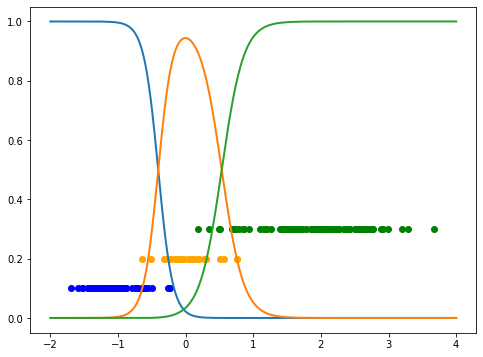

In [6]:
c1 = np.random.normal(loc=-1.0, scale=0.3, size=(60, 1))
c2 = np.random.normal(loc=0.0, scale=0.3, size=(30, 1))
c3 = np.random.normal(loc=2.0, scale=0.7, size=(90, 1))
inputs = np.concatenate((c1, c2, c3), axis=0)
targets = np.array([0,]*c1.size + [1,]*c2.size + [2,]*c3.size)

model = LogisticRegression(1, 3)
opt_result = model.train(inputs, targets, method='cg', maxiter=10)
print(opt_result)
                                                                                                    
c1_probs = model.probs(c1)                                                                       
c2_probs = model.probs(c2)                                                                       
c3_probs = model.probs(c3)                                                                       
                                                                                                    
print("c1:")                                                                                    
print(model.labels(c1))                                                                          
print("c2:")                                                                                    
print(model.labels(c2))                                                                          
print("c3:")                                                                                    
print(model.labels(c3))                                                                          
                                                                                                    
x = np.linspace(-2.0, 4.0, 500)[:, None]
x_probs = model.probs(x)                                                                         
                                                                                                    
plt.plot(x, x_probs, linewidth=2)
plt.scatter(c1, np.zeros_like(c1) + 0.1, color='blue');
plt.scatter(c2, np.zeros_like(c2) + 0.2, color='orange');
plt.scatter(c3, np.zeros_like(c3) + 0.3, color='green');

In [7]:
# covariance matrix for each training class
cov = [[1, -0.8],
       [-0.8, 1]]

# red data
red = np.random.multivariate_normal((-1, -1), cov, 500)

# green data
green = np.random.multivariate_normal((0, 0), cov, 300)

# blue data
blue = np.random.multivariate_normal((1, 1), cov, 400)

inputs = np.vstack((red, green, blue))
targets = np.array(([0,]*red.shape[0] + [1,]*green.shape[0] + [2,]*blue.shape[0]))

# min and max training values                                                                   
mn = np.min(inputs, axis=0)
mx = np.max(inputs, axis=0)

# train model
model2 = LogisticRegression(2, 3)
opt_result = model2.train(inputs, targets)

print('optimization result:')
print(opt_result)

# find class labels
red_labels = model2.labels(red)
green_labels = model2.labels(green)                                                                 
blue_labels = model2.labels(blue)                                                                   
                                                                                                    
print("\nred labels:")
print(red_labels)                                                                                 
print("\ngreen labels:")
print(green_labels)                                                                               
print("\nblue labels:")
print(blue_labels)

optimization result:
     fun: 0.17691275683423843
     jac: array([ 3.0027e-06, -3.3743e-05,  3.0741e-05, -2.1082e-05,  2.5879e-05,
       -4.7975e-06,  1.6410e-07, -8.1736e-06,  8.0095e-06])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 384
     nit: 51
    njev: 373
  status: 2
 success: False
       x: array([-4.2806,  0.6887,  5.537 , -5.4893, -0.6061,  4.5555, -0.9736,
        3.3094, -1.6695])

red labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0

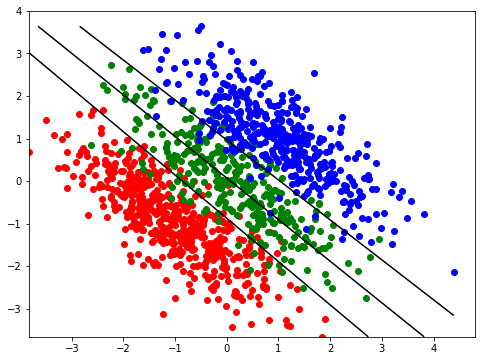

In [8]:
# first figure shows training data and class intersections
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# training data
ax.scatter(red[:,0],   red[:,1],   color='red')
ax.scatter(green[:,0], green[:,1], color='green')
ax.scatter(blue[:,0],  blue[:,1],  color='blue')

# generate grid over training data
sw = 0.02
sx = np.arange(mn[0], mx[0], sw)
sy = np.arange(mn[1], mx[1], sw)
x, y = np.meshgrid(sx, sy, copy=False)

# get probability densities and labels for values in grid
z = np.vstack((x.reshape((-1,)), y.reshape((-1,)))).T
probs = model2.probs(z)

# red, green, blue and max probability densities
redp = np.reshape(probs[:,0,None], x.shape)
greenp = np.reshape(probs[:,1,None], x.shape)
bluep = np.reshape(probs[:,2,None], x.shape)
maxp = np.reshape(np.max(probs, axis=1), x.shape)

# class intersections
diff_rg = redp   - greenp
diff_rb = redp   - bluep
diff_gb = greenp - bluep
ax.contour(x, y, diff_rg, colors="black", levels=(0,));
ax.contour(x, y, diff_rb, colors="black", levels=(0,));
ax.contour(x, y, diff_gb, colors="black", levels=(0,));

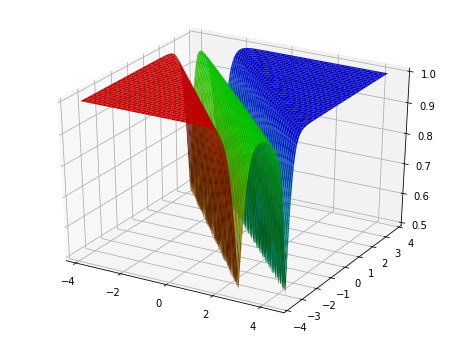

In [9]:
# second figure shows 3d plots of probability densities
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# straight class colors for suface plots
color = np.reshape((redp, greenp, bluep), (3, x.shape[0], x.shape[1]))
color = color.swapaxes(1, 2).T

# flip colors to fade to white
zro = np.zeros_like(x)
color_flip = np.ones((3, x.shape[0], x.shape[1]))
color_flip -= (
    np.array((zro, redp, redp)) +
    np.array((greenp, zro, greenp)) +
    np.array((bluep, bluep, zro))
)
color_flip -= np.min(color_flip)
color_flip /= np.max(color_flip)
color_flip = color_flip.swapaxes(1, 2).T

# probability density surface
surf = ax.plot_surface(x, y, maxp, facecolors=color_flip,
                       linewidth=0.02, shade=True)

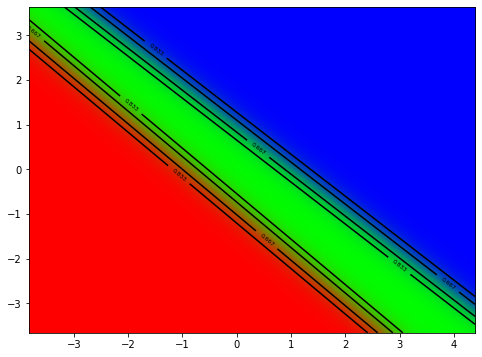

In [10]:
# third figure shows contours and color image of probability densities
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#ax.pcolor(x, y, pMax)
ax.imshow(color_flip, origin='lower',
          extent=(mn[0], mx[0], mn[1], mx[1]), aspect='auto')

# contours
nlevel = 4
cs = ax.contour(x, y, maxp, colors='black',
                levels=np.linspace(np.min(maxp), np.max(maxp), nlevel));
cs.clabel(fontsize=6);

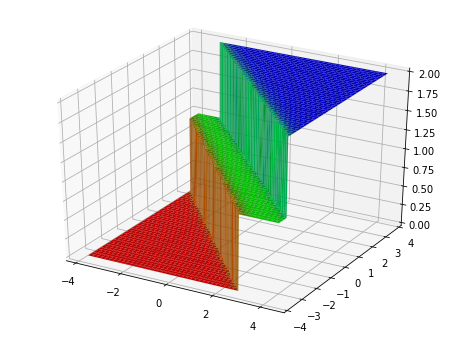

In [11]:
# fourth figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

labels = model2.labels(z)
lmax = np.reshape(labels, x.shape)

surf = ax.plot_surface(x, y, lmax, facecolors=color_flip, linewidth=0.02)
surf.set_edgecolor('black')

Just some tinkering around with NumPy indexing... I'll delete this once I'm sure it's how I want it above.

In [12]:
a = np.random.random((10, 12))
b = np.random.random(10*12)

a.flat[...] = b

a, b

(array([[0.9374, 0.4288, 0.7131, 0.1403, 0.383 , 0.4339, 0.1938, 0.3942,
         0.4333, 0.9889, 0.7661, 0.3381],
        [0.6866, 0.337 , 0.9707, 0.821 , 0.9996, 0.7375, 0.0256, 0.7157,
         0.1607, 0.7908, 0.4953, 0.6156],
        [0.1906, 0.6906, 0.389 , 0.403 , 0.6915, 0.6434, 0.4763, 0.0767,
         0.2177, 0.4538, 0.1972, 0.559 ],
        [0.5921, 0.313 , 0.7751, 0.5399, 0.7835, 0.7717, 0.1334, 0.976 ,
         0.571 , 0.7327, 0.2284, 0.695 ],
        [0.9025, 0.9744, 0.9114, 0.4037, 0.3758, 0.6529, 0.687 , 0.3019,
         0.3724, 0.4931, 0.3388, 0.4703],
        [0.3928, 0.3209, 0.524 , 0.3652, 0.1105, 0.0058, 0.8361, 0.8904,
         0.9851, 0.8351, 0.1709, 0.4648],
        [0.6085, 0.9261, 0.7292, 0.2257, 0.6813, 0.8392, 0.5364, 0.9569,
         0.9985, 0.7699, 0.7478, 0.5385],
        [0.3274, 0.2812, 0.8117, 0.5617, 0.5937, 0.3657, 0.5262, 0.1177,
         0.0338, 0.0086, 0.9224, 0.6039],
        [0.3436, 0.2238, 0.4701, 0.7314, 0.1759, 0.2624, 0.7809, 0.8777,
       

In [13]:
a = np.random.random((2, 4, 3))
g = np.array([0, 0, 2, 1])
a.shape, a[..., range(a.shape[1]), g].shape
a, a[..., range(a.shape[-2]), g]

(array([[[0.9329, 0.0729, 0.9261],
         [0.0735, 0.7501, 0.5765],
         [0.3502, 0.4609, 0.2619],
         [0.5983, 0.5326, 0.4089]],
 
        [[0.5251, 0.9015, 0.552 ],
         [0.5101, 0.4533, 0.4804],
         [0.1491, 0.3291, 0.8884],
         [0.4288, 0.0692, 0.23  ]]]), array([[0.9329, 0.0735, 0.2619, 0.5326],
        [0.5251, 0.5101, 0.8884, 0.0692]]))

In [14]:
a = np.random.random((4, 3))
g = np.array([0, 0, 2, 1])
print(g, g.shape)
print(a, a.shape)
print(a[range(a.shape[0]), g], a[range(a.shape[0]), g].shape)

[0 0 2 1] (4,)
[[0.496  0.6593 0.8895]
 [0.2379 0.8145 0.9321]
 [0.5755 0.7309 0.5947]
 [0.9804 0.0062 0.181 ]] (4, 3)
[0.496  0.2379 0.5947 0.0062] (4,)


In [15]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])
rows, cols = np.indices(a.shape[:-1])
a, a[rows, cols, g]

(array([[[0.2921, 0.7811, 0.0456],
         [0.5535, 0.1995, 0.4072],
         [0.8935, 0.3706, 0.8387],
         [0.4168, 0.6342, 0.114 ]],
 
        [[0.5173, 0.4576, 0.7841],
         [0.8442, 0.2437, 0.5798],
         [0.0573, 0.2975, 0.1114],
         [0.6421, 0.826 , 0.4424]]]), array([[0.2921, 0.5535, 0.8387, 0.6342],
        [0.5173, 0.8442, 0.2975, 0.4424]]))

In [16]:
a = np.random.random((4, 3))
g = np.array([0, 0, 2, 1])[:, None]
a, np.take_along_axis(a, g, axis=-1)

(array([[0.2784, 0.9786, 0.6734],
        [0.238 , 0.1896, 0.0214],
        [0.9456, 0.4239, 0.3615],
        [0.5978, 0.6271, 0.4268]]), array([[0.2784],
        [0.238 ],
        [0.3615],
        [0.6271]]))

In [17]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])[..., None]
a, np.take_along_axis(a, g, axis=-1)

(array([[[0.2294, 0.2059, 0.7215],
         [0.3674, 0.1636, 0.4568],
         [0.8738, 0.0384, 0.2651],
         [0.5913, 0.659 , 0.8068]],
 
        [[0.8295, 0.8792, 0.7759],
         [0.6218, 0.8878, 0.5127],
         [0.879 , 0.4836, 0.3166],
         [0.7215, 0.9522, 0.6322]]]), array([[[0.2294],
         [0.3674],
         [0.2651],
         [0.659 ]],
 
        [[0.8295],
         [0.6218],
         [0.4836],
         [0.6322]]]))

In [18]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])

a, a.reshape((-1, a.shape[-1]))[range(2*4), g.flat].reshape(g.shape)

(array([[[0.4037, 0.5447, 0.2956],
         [0.4054, 0.2416, 0.1803],
         [0.5435, 0.4829, 0.2587],
         [0.0337, 0.4324, 0.1882]],
 
        [[0.3849, 0.0718, 0.7135],
         [0.5615, 0.9119, 0.6216],
         [0.8974, 0.468 , 0.8754],
         [0.0304, 0.1624, 0.7616]]]), array([[0.4037, 0.4054, 0.2587, 0.4324],
        [0.3849, 0.5615, 0.468 , 0.7616]]))

In [19]:
a = np.random.random((2, 4))
g = np.array([0, 1])

a, np.take_along_axis(a, g[:, None], axis=-1)
a, a[range(a.shape[0]), g]

(array([[0.4928, 0.8243, 0.5146, 0.3123],
        [0.9598, 0.1656, 0.6512, 0.2217]]), array([0.4928, 0.1656]))

In [20]:
(3,) * 4

(3, 3, 3, 3)